# Summary 

Our study suggests that the implementation of the prior-authorisation policy **did have a salient impact** on the usage of the atypical anti-psychotic drugs. We saw that **after the policy intervention, there was a proven drop in level of the nonpreferred drug usage, which was dininishing at a noticeable pace every year.**

#Load Packages

In [1]:
#Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

#Data


<details>

<summary> **Data Source** </summary>
Dr. MR Law et al. Effect of Prior Authorisation of Second-Generation Antipsychotic Agents on Pharmacy Utilisation and Reimbursement.


The data consists of three demensions: State name, the quarter of the year, and the marketshare.

We will conduct an **interrupted time series (ITS)** analysis to evaluate the authorisation form policy's impact on the atypical antipsychotics uses. The **outcome variable** will be the drug's market share, defined as: The total amount spent on nonpreferred medications devided by the total amount spent on all the antipsychotics in each quarter.

#The Control Group

To avoid potential threats to the validity, we introduce the control group into our analysis, as seen in the dataset "state" column that after the WV comes the **control** variables. 

In our case, the control group is **the other 38 States that did not implement the prior-authorisation policy**. The outcome variable, which is the market share, is presented as the **weighted average** of these 38 states market share.

<details>
<summary> --- Why do we need the control group --- </summary>

Confounding effects or co-interventions can undermine the validity of the analysis. 

The control group usually has silimar characteristics or trends to the intervention group (the targeted group, in our case the WV). 

If we assumed that the policy intervention has an effect on our intervention group, then we would expect a change in patterns for that group. We would also expect that the control group remains intact because it is not exposed to the intervention. 

However, if the control group movement also changes, then it implies that there might be other confounders / co-interventions that affect both groups, rather than the intervention we are investigating. That's why we need the control group. We want to make sure any other confounders are excluded from the studies based on observing the patterns of both groups.

In [19]:
data = pd.read_csv('antipsychotic_study_control.csv')
display(data.head())
display(data.tail())

,state,yearqtr,market_share
0,WV,"2001, 2",0.52714
1,WV,"2001, 3",0.49988
2,WV,"2001, 4",0.49205
3,WV,"2002, 1",0.49713
4,WV,"2002, 2",0.49724


,state,yearqtr,market_share
33,Control,"2004, 4",0.47537
34,Control,"2005, 1",0.46563
35,Control,"2005, 2",0.45466
36,Control,"2005, 3",0.45886
37,Control,"2005, 4",0.45484


#Variables for ITS

There are two core elements that an ITS model address: **Level and Trend**. 

The level stands for the immediate changes after the intervention, and the trend is the changes in slope.

The model we will use to conduct an ITS is the following:

    For intervention status j, for group k (Niles), at time t:
    
    outcome(jkt) = β0 + β1 * time(t) + β2 * group(k) + β3 * time(t) * group(k) 
    + β4 * level(jt) + β5 * trend(jt) + β6 * level(jt) * group(k) + β7 * trend(jt) * group(k) + ϵ(jkt)

Here are the explanations of the implications of the coefficients:

β0 is the intercept

β1 is the secular trend of the control variable

β2 is the exisiting level different between control and intervention group

β3 is the trend difference in the baseline period

--- intervention ---

β4 / β5 are the level / trend changes in the control group respectively. In an ITS with a control group, we will estimate the counterfactual by looking at what happens in the control group would be shared by the intervention group, were there no interventions

β6 / β7 are the level / trend changes in the intervention group respectively.

To run the above-mentioned model, some variables additions to the dataset are needed:


In [20]:
# Function for adding time, level and trend columns
def add_time_level_trend(df, state, start_period='2003, 2'):
    df['time'] = np.arange(1, len(df) + 1)
    df['level'] = (df['yearqtr'] >= start_period).astype(int)
    df['trend'] = df['level'].cumsum()
    if state == 'WV':
        df['wvtime'] = df['time']
        df['wvlevel'] = df['level']
        df['wvtrend'] = df['trend']
    else:
        df[['wvtime', 'wvlevel', 'wvtrend']] = 0
    return df

In [ ]:
# Split the data into two sets
wv = data[data['state'] == 'WV']
control = data[data['state'] == 'Control']

# Add time, level, trend columns to both sets
wv = add_time_level_trend(wv, 'WV')
control = add_time_level_trend(control, 'Control')

# Concatenate the two frames
data = pd.concat([wv, control])

# Add west_virginia column
data['west_virginia'] = (data['state'] == 'WV').astype(int)

In [7]:
#Take a glimpse
print(data.head(10))

  state  yearqtr  market_share  time  level  trend  wvtime  wvlevel  wvtrend  \
0    WV  2001, 2       0.52714     1      0      0       1        0        0   
1    WV  2001, 3       0.49988     2      0      0       2        0        0   
2    WV  2001, 4       0.49205     3      0      0       3        0        0   
3    WV  2002, 1       0.49713     4      0      0       4        0        0   
4    WV  2002, 2       0.49724     5      0      0       5        0        0   
5    WV  2002, 3       0.49729     6      0      0       6        0        0   
6    WV  2002, 4       0.49972     7      0      0       7        0        0   
7    WV  2003, 1       0.50085     8      0      0       8        0        0   
8    WV  2003, 2       0.46391     9      1      1       9        1        1   
9    WV  2003, 3       0.43430    10      1      2      10        1        2   

   west_virginia  
0              1  
1              1  
2              1  
3              1  
4              1  
5    

Now we have the variables required for an ITS, we will insepct the data by making a chart.

#Exploratory Analysis

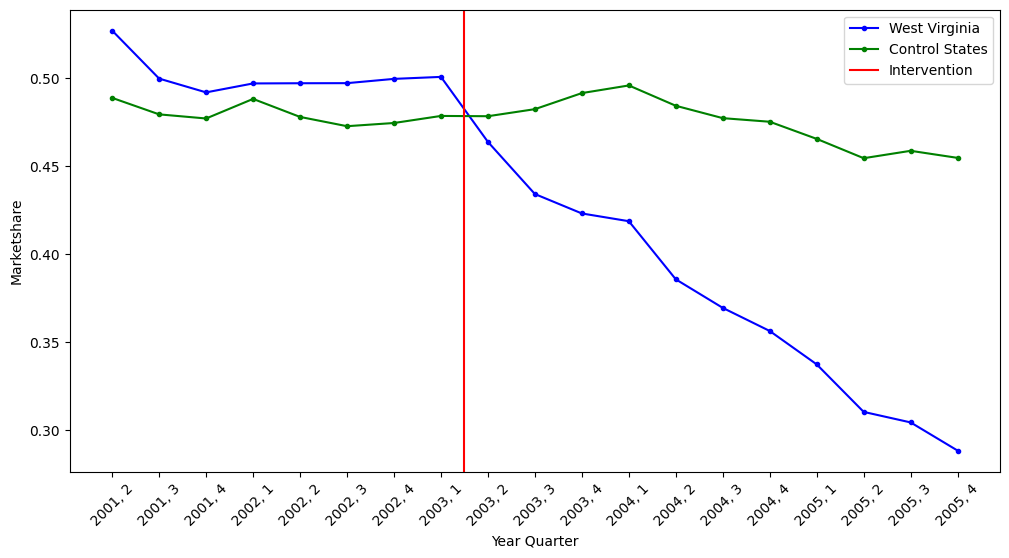

In [22]:
#Plot the data
fig, ax = plt.subplots(figsize=(12, 6))

wvend = 19
ax.plot(data['time'][:wvend], data['market_share'][:wvend], 
        marker='.', color='blue', label='West Virginia')
ax.plot(data['time'][wvend:], data['market_share'][wvend:],
        marker='.', color='green', label='Control States')

#Intervention
ax.axvline(x=8.5, color='red', label='Intervention')

#Format
ax.set(xlabel='Year Quarter', 
       ylabel='Marketshare',)
time_label=data['time'][:wvend].tolist()
yearqrt_label=data['yearqtr'][:wvend].tolist()
ax.set_xticks(time_label)
ax.set_xticklabels(yearqrt_label)
ax.legend(loc='best')
plt.xticks(rotation=45)

#Show the plot
plt.show()

We see that the intervention group (WV) was relatively flat, but encountered **a linear decreases after the intervention**. 


At the same time, the control group stays pretty flat throughout the time, slightly fluctuating within 45% and 50% without any large deviation. This implies that **it is a good non-equivalent control group** to compare with the patterns of the intervention group. 


There is no wild outliers in the dataset. 

The data seem flat throughout the time, suggesting no co-intervention existing. Both group present linear patterns before and after interventions, which is ideal for fitting a linear model without requiring additional transformations. 

#Preliminary Model

In [9]:
#Standard OLS regression with no control for autocorrelation
model_ols = smf.ols('market_share ~ time + west_virginia + wvtime + level + trend + wvlevel + wvtrend', data = data).fit()

print(model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:           market_share   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     329.4
Date:                Thu, 11 Jul 2024   Prob (F-statistic):           1.43e-26
Time:                        14:55:52   Log-Likelihood:                 135.48
No. Observations:                  38   AIC:                            -255.0
Df Residuals:                      30   BIC:                            -241.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.4862      0.006     81.001

<details>

<summary> --- Meanings of each variable --- </summary>

The intercept stands for the existing baseline of the control group.

Time: The secular trend (trend that already existed) in the control group.  Not statistical significant.

West Virginia: The difference in level between WV and control group.

Level / Trend / WVlevel / WVtrend: The level and trend changes in the control group (Other states)/intervention group (West Virginia) **after the policy intervention**.

##Interpretation


**After the intervention**, we observe that: 

**There is a 3.8% decrease of level (p=0.001) in WV marketshare after the intervention**

**Each quarter around 1.3% decrease (p=0) in marketshare is expected** (Both highly statistically significant)

There is also a slight level increase (2%, p=0.005) in the control group.


#Addressing Autocorrelations

One common issue to address in the ITS is autocorrelations: The relationships between data points overtime. 

An important assumption for the OLS model is that the individual observations should be independent. If the time series are correlated overtime, then it breaks the assumption of the data points independence. Additional modifications, such as introduce an ARIMA models, will be needed.

We will use four methods to assess the autocorrelations in our dataset: Durbin-Watson Test, a residual plot, a autocorrelation function plot (ACF), and a partial autocorrelation function plot (PACF).

In [23]:
#Durbin watson test to examine autocorrelation
from statsmodels.stats.stattools import durbin_watson

durbin_watson(model_ols.resid)

1.5711123314155595

Durbin-Watson test examines the autocorrelation in the residuals from a regression model. The test statistics range from 0 to 4. The closer it approaches 2, the stroger the evidence suggesting that the residual has no autocorrelation. A value between closer to 0 suggests a positive autocorrelatioon, while to 4, a negative autocorrelation.


Here we get the DWT statisic as **1.57**. Although staying within an acceptable range, 1.5 to 2.5, it is still **not a strong evidence to indicate a non-autocorrelation**.

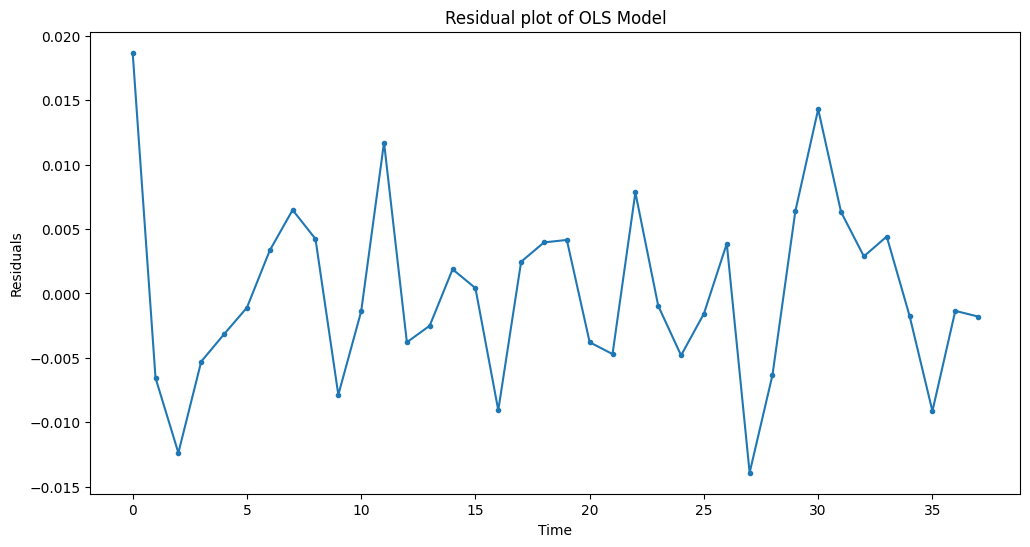

In [24]:
#Residual Plots
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(model_ols.resid, marker='.')
ax.set(xlabel='Time', ylabel='Residuals', title='Residual plot of OLS Model')

plt.show()

From the residual plot, we see no clear cyclical patterns or corrleations between the residuals, which is ideal.

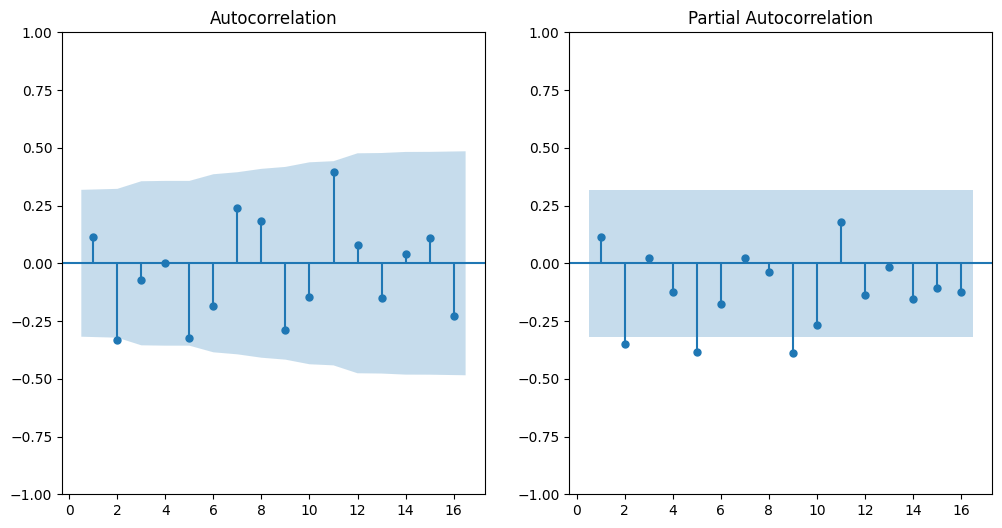

In [25]:
#ACF and PACF Plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(12, 6), ncols=2, nrows=1)
plot_acf(model_ols.resid, zero=False, ax=ax[0])
plot_pacf(model_ols.resid, zero=False, ax=ax[1])

plt.show()

Strong and clear patterns suggesting an autoregressive (AR) or moveing average (MA) are not spotted in both the ACF and PACF plots. However, the ACF plot are showing a very weak expotential decrease overtime, and the PACF plot shows a significant spikes when the lags = 2, 4, ..., slightly suggesting an AR model as ideal.

We will use a generalised least squared model with AR(1) or AR(2) to control for any correlations between the quarters, given what the PACF plot indicated.

#Choose the Final Model

First, we create the two models: AR1 and AR2.

In [26]:
#Import ARIMA
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
#AR1 Model
ar1 = ARIMA(data['market_share'],
            data[['time', 'west_virginia', 'wvtime', 
                   'level', 'trend', 'wvlevel', 'wvtrend']],
            order=(1,0,0)).fit(gls=True)

#AR2 Model
ar2 = ARIMA(data['market_share'],
            data[['time', 'west_virginia', 'wvtime', 
                   'level', 'trend', 'wvlevel', 'wvtrend']],
            order=(2,0,0)).fit(gls=True)

After having the models, we will now use some different methods to assess the goodness of the two models. 

**(1.) Information Criteria**

Akaike Information Criteria (AIC) and Beyesian Information Criteria (BIC). Both are the metrics that measure the goodness of the models by calculating the fitness score while taking the penalties to avoid the complexity. **Lower IC values** are preferred when choosing the model.


**(2.) Diagnostics Plot**

4 plots: Standardised residuals, estimated density, QQ and correlogram, to investigate whether the model provides good fit.


**(3.) Likelihood Test**

A test that determines if the two models fit the data equally well or not and, therefore, which one should be a better option.


##(1.) Information Criteria

In [28]:
#Compare the information criteria
print("AR1 Model's AIC:", ar1.aic, "; AR2 Model's AIC:", ar2.aic)
print("AR1 Model's BIC:", ar1.bic, "; AR2 Model's BIC:", ar2.bic)

AR1 Model's AIC: -251.69257310971483 ; AR2 Model's AIC: -257.6673989541771
AR1 Model's BIC: -235.31671151245098 ; AR2 Model's BIC: -239.65395119718684


##(2.) Diagnostics Plot

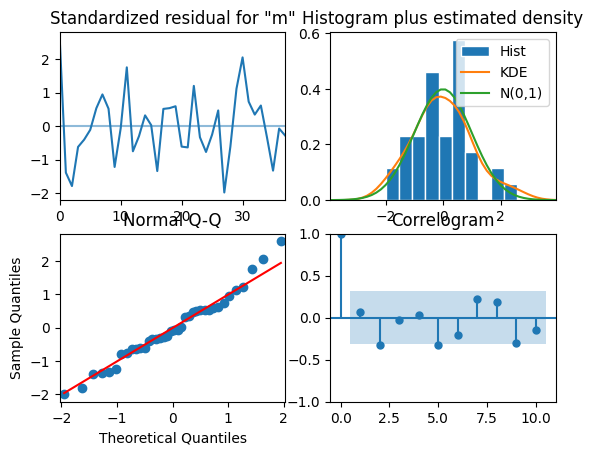

In [29]:
#AR1's diagnostics plot
ar1.plot_diagnostics()
plt.show()

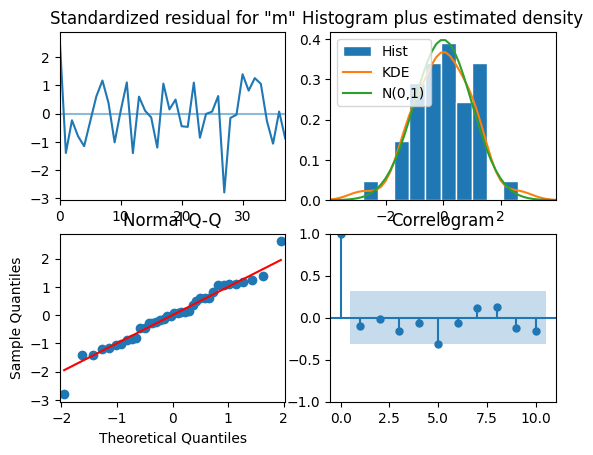

In [17]:
#AR2's diagnostics plot
ar2.plot_diagnostics()
plt.show()

The diagnostics plot consists of four plots to assess the fitness of the model. First, the standardised residual plots both show very random patterns for the tow models. However, the density plot indicates that AR2 model's residuals are more concordant with the normal distribution (the similarity between green and orange lines), and the QQ plot also suggests the same message with most of the blue points lying perfectly on the red line. The Correlogram of AR2 has less statistically significant autocorrelations than that of AR1. 

##(3.) Likelihood Test
We have AR(1) and AR(2) models. To determine if the two models are significantly different, we will perform the likelihood test with the folloing hypotheses:


**Null hypothesis**: No significant difference between the two models. They fit the data equally well. We should use the AR1 (reduced model) one.

**Alternative hypothesis**: There is significant difference between the two models. We should use the AR2 (full model) one.

In [30]:
full_llf = ar2.llf #Full model (AR2) Log Likelihood
reduced_llf = ar1.llf #Reduced model (AR1) Log Likelihood

#Calculate the likelihood ratio Chi-squared Statistics
LR_statistics = -2 * (reduced_llf - full_llf)

#Calculate the P-value
import scipy
p_value_llf = scipy.stats.chi2.sf(LR_statistics, 2)

if p_value_llf > 0.05:
  print(f'P-value is {p_value_llf}. Fail to reject the null hypothesis.',
        'The two models fit the data equally well. Stay with the reduced model (AR1)')
else:
  print(f'P-value is {p_value_llf}. Reject the null hypothesis.',
        'We should use the full model (AR2)')

P-value is 0.01854763628140005. Reject the null hypothesis. We should use the full model (AR2)


With the above assessments, we will choose the **AR2 model** for our analysis.

#The Result

In [31]:
#AR2 Model Summary
print(ar2.summary())

                               SARIMAX Results                                
Dep. Variable:           market_share   No. Observations:                   38
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 139.834
Date:                Thu, 11 Jul 2024   AIC                           -257.667
Time:                        19:00:28   BIC                           -239.654
Sample:                             0   HQIC                          -251.258
                                 - 38                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.4883      0.008     62.235      0.000       0.473       0.504
time             -0.0019      0.002     -1.047      0.295      -0.005       0.002
west_virginia     0.0228      0.009     

In [33]:
intervention = 8 #Where the policy (intervention) started
wvend = 19 #Where the WV ends in the dataframe

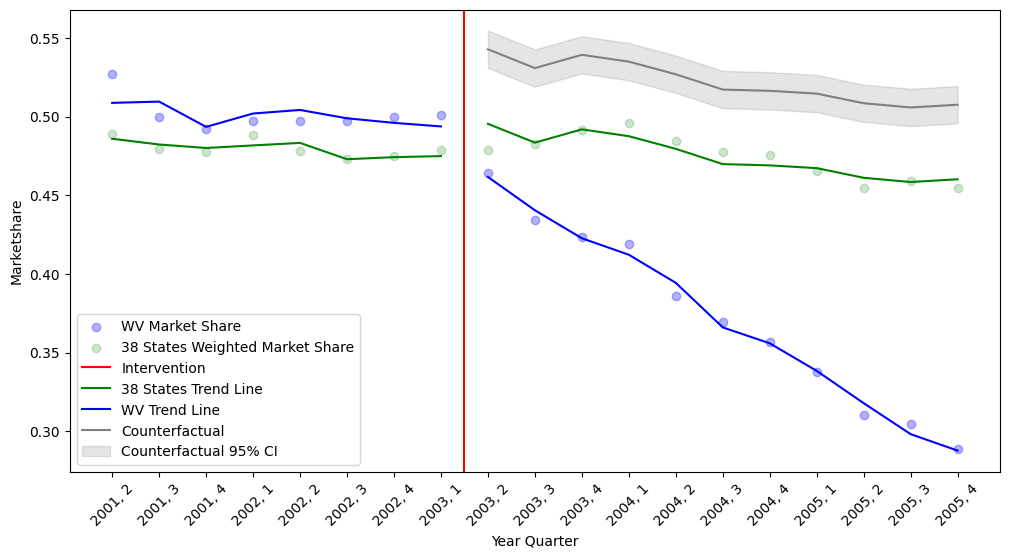

In [36]:
#Figure Basic Layout
fig, ax=plt.subplots(figsize=(12,6))
ax.scatter(data['time'][:wvend], data['market_share'][:wvend], 
           color='blue', alpha=0.3, label='WV Market Share')
ax.scatter(data['time'][wvend:], data['market_share'][wvend:],
           color='green', alpha=0.2, label='38 States Weighted Market Share')

#Intervention Line
ax.axvline(x=8.5, color='red', label='Intervention')

#Trend line of the 38 States (Control Group)
#First, we need to get the predictions data generated by the model
predictions_38 = ar2.get_prediction(start=wvend, end=data.shape[0]-1)
summary_38 = predictions_38.summary_frame(alpha=0.05)
preds_38 = predictions_38.predicted_mean

#Then, plot the trend line
ax.plot(data['time'][:intervention], preds_38[:intervention],
        color='green', label='38 States Trend Line')
ax.plot(data['time'][intervention:wvend], preds_38[intervention:wvend],
        color='green')

#Trend line of West Virginia (Intervention Group)
#Same, let's get the predictions first
predictions_wv = ar2.get_prediction(start=0, end=wvend-1)
summary_wv= predictions_wv.summary_frame(alpha=0.05)
preds_wv = predictions_wv.predicted_mean

#Then, plot the trend line
ax.plot(data['time'][:intervention], preds_wv[:intervention],
        color='blue', label='WV Trend Line')
ax.plot(data['time'][intervention:wvend], preds_wv[intervention:wvend],
        color='blue')

#Counterfactual part for the Intervention Group
#Were it no interventions, WV would follow the pattern of the control group
diff_wv_38 = ar2.params[2] #Secular level differnce between WV and 38 States
level_38 = ar2.params[4] #Control group's level change after the intervention

cf_wv = summary_38[['mean', 'mean_ci_lower', 'mean_ci_upper']] + diff_wv_38 + level_38 
cf_wv = cf_wv[intervention:wvend]

#Plot this counterfactual trend line to the Intervention Group
ax.plot(data['time'][intervention:wvend], cf_wv['mean'], color='grey',
        label='Counterfactual')
ax.fill_between(data['time'][intervention:wvend],
                cf_wv['mean_ci_lower'], cf_wv['mean_ci_upper'],
                alpha=0.1, color='k',
                label='Counterfactual 95% CI')

#Formatting
ax.set(xlabel='Year Quarter', 
       ylabel='Marketshare',)
time_label=data['time'][:wvend].tolist()
yearqrt_label=data['yearqtr'][:wvend].tolist()
ax.set_xticks(time_label)
ax.set_xticklabels(yearqrt_label)
ax.legend(loc='best')
plt.xticks(rotation=45)

#Show the plot
plt.show()

##Findings:

After the implementation of the policy, there was a noticeable drop in West Virginia's atypical antipsychotic drugs market share of 3.7% (p=0.001, [-5.9%, -1.6%]) relative to the change in other 38 states which did not launch the policy. We also see a sustained decrease of 1.4% (p=0, [-1.8%, -1%]) in marketshare each quarter since the policy went into effect. 

As for the states without the policy, there is an immediate 2.5% increase (p=0.007, [0.7%, 4.2%]) of the nonpreferred drug's marketshare, while the trend change is not virtually existent (p=0.3, not statistically significant).

#Conclusion

In our analysis, we have used statistical methods and ITS to construct the casual relationship between the drug authorisation form policy and the usage of the targeted drugs. Despite the proof of the intended decreases in the nonprefered drugs usage, some unwanted effects of the policy still needed to be considered. For example, whether the policy will redirect the patients to the unregulated markets for such drugs, or the doctors would turn to other treatments that might be less efficient or more costly. Further investigations and policy evaluations are needed to ensure the best outcomes for the both medical systems and the government.